<a href="https://colab.research.google.com/github/Habonit/sparta_coding_ai/blob/main/week7_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week7 Advanced

- 1) 과제: SFT trainer를 통해 100개 샘플 훈련

- 2) 이번에 논문 요약 서비스를 구현하고 있는데 해당 서비스에 sft로 훈련한 모델을 적용하여 api와의 성능을 비교해볼 것입니다. 이것은 다음주까지 진행할 예정입니다.

In [ ]:
!pip install -q datasets transformers trl evaluate rouge_score

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
import wandb

wandb.login()

wandb: Currently logged in as: khk172216 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Load Dataset

-1) 데이터셋을 불러옵니다.

-2) train: val: test = 70개 : 20개 : 10개

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM

dataset = load_dataset("json", data_files="corpus.json")["train"]

train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.select(range(train_size))
val_dataset = dataset.select(range(train_size, train_size + val_size))
test_dataset = dataset.select(range(train_size + val_size, len(dataset)))

In [ ]:
train_dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 70
})

In [ ]:
val_dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 20
})

In [ ]:
test_dataset

Dataset({
    features: ['instruction', 'input', 'output'],
    num_rows: 10
})

In [ ]:
test_dataset['instruction']

['클라우드 AI (Cloud AI)이 무엇인지 설명해줘',
 'API 기반 AI 서비스 (AI-as-a-Service)이 무엇인지 설명해줘',
 '데이터 레이블링 (Data Labeling)이 무엇인지 설명해줘',
 'MLOps (Machine Learning Operations)이 무엇인지 설명해줘',
 'Explainable AI (XAI, 설명 가능한 AI)이 무엇인지 설명해줘',
 '시계열 분석 (Time Series Analysis)이 무엇인지 설명해줘',
 '오픈소스 프레임워크 (TensorFlow, PyTorch)이 무엇인지 설명해줘',
 'ONNX (Open Neural Network Exchange)이 무엇인지 설명해줘',
 'AutoML (자동화 머신러닝)이 무엇인지 설명해줘',
 'AI 모델 배포 (AI Model Deployment)이 무엇인지 설명해줘']

In [ ]:
test_dataset['output']

['클라우드 AI는 클라우드 컴퓨팅 환경에서 제공되는 인공지능 기술과 서비스를 의미합니다. 이를 통해 사용자는 대규모 데이터 처리, 기계 학습, 자연어 처리 등의 AI 기능을 쉽게 활용할 수 있습니다. 클라우드 AI는 일반적으로 높은 처리 능력과 저장 용량을 제공하여 기업과 개인이 복잡한 AI 모델을 학습시키고 운영할 수 있도록 돕습니다. 또한, 사용자는 필요에 따라 리소스를 확장하거나 축소할 수 있어 유연한 비용 관리를 할 수 있습니다. 대표적인 클라우드 AI 서비스에는 구글 클라우드 AI, 아마존 웹 서비스(AWS), 마이크로소프트 애저 등이 있습니다.',
 'API 기반 AI 서비스(AI-as-a-Service)는 클라우드 기반 플랫폼에서 AI 기능을 제공하는 서비스입니다. 사용자는 복잡한 AI 모델을 구축하지 않고도 API를 통해 기계 학습, 자연어 처리, 이미지 분석 등의 기능을 쉽게 활용할 수 있습니다. 이러한 서비스는 개발자들이 빠르게 AI 기술을 통합하여 애플리케이션을 개발할 수 있도록 지원합니다. 또한, 비용 효율성 및 확장성을 제공하여 필요에 따라 서비스를 이용할 수 있는 장점이 있습니다. 대표적인 예로는 구글의 AI 플랫폼, 아마존의 SageMaker 등이 있습니다.',
 "데이터 레이블링(Data Labeling)은 기계 학습과 인공지능 모델을 학습시키기 위해 데이터를 식별하고 주석을 달아주는 과정입니다. 이 과정에서는 이미지, 텍스트, 오디오 등의 데이터에 특정 태그나 클래스를 부여하여 모델이 데이터를 이해할 수 있게 만듭니다. 예를 들어, 이미지 인식 모델을 위해 고양이와 개의 이미지를 각각 '고양이', '개'로 레이블링할 수 있습니다. 데이터 레이블링은 일반적으로 수작업으로 이루어지며, 정확한 레이블링이 모델의 성능에 큰 영향을 미칩니다. 최근에는 자동화된 레이블링 도구나 반자동화 기법도 개발되고 있습니다.",
 'MLOps는 머신러닝 모델의 개발, 배포, 운영 및 유지 관리를 위한 실용적인 방법론입니다. 이는 IT 운영과 데이터 과

# Data Preprocessing

- 1) 대표적인 모델인 LLAMA 3.2 1b 모델을 사용합니다.

- 2) LLAMA는 SFT를 진행하기 위해선 {"text": prompt} 데이터를 만들면 됩니다.

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-1B").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-1B")
tokenizer.pad_token = tokenizer.eos_token  # LLaMA는 기본적으로 pad_token이 없으므로 eos_token 사용

def format_llama_prompt(example):
    prompt = f"### 질문: {example['instruction']}\n### 답변: {example['output']}"
    return {"text": prompt}

def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        max_length=512
    )

train_dataset = train_dataset.map(format_llama_prompt).map(tokenize_function, batched=True)
val_dataset = val_dataset.map(format_llama_prompt).map(tokenize_function, batched=True)
test_dataset = test_dataset.map(format_llama_prompt).map(tokenize_function, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/10 [00:00<?, ? examples/s]

# Training Args Setting

In [ ]:
from transformers import TrainingArguments
from trl import SFTTrainer
from transformers import AutoModelForCausalLM

training_args = TrainingArguments(
    output_dir="./llama-3.2-1B-sft",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    fp16=True,
    save_total_limit=2,
    push_to_hub=False,
    report_to="wandb",
    run_name="week7_advanced_llama_finetuning",
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    load_best_model_at_end=True,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-13-3b5126fad110>:27: FutureWarning: `tokenizer` is deprecated and removed starting from version 0.16.0 for `SFTTrainer.__init__`. Use `processing_class` instead.
  trainer = SFTTrainer(
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Metric Comparision

- 1) Bleu와 Rouge Score를 사용하여 훈련 전후의 매트릭을 비교해 훈련의 효과를 검증해볼 예정입니다.

- 2) 나아가 훈련한 모델이 generate한 output과 openai api로 제작한 데이터와의 차이를 육안으로 확인해볼 예정입니다.

In [ ]:
from transformers import pipeline
import torch

model.eval()

def generate_responses(prompts, max_length=256):
    inputs = tokenizer(prompts, padding=True, truncation=True, return_tensors="pt").to("cuda")  # 배치 처리
    with torch.no_grad():
        output_ids = model.generate(**inputs, max_new_tokens=max_length, eos_token_id=tokenizer.eos_token_id)

    responses = tokenizer.batch_decode(output_ids, skip_special_tokens=True)  # 배치 디코딩
    return responses

prompts = test_dataset["instruction"]
outputs = test_dataset["output"]
generated_responses = generate_responses(prompts)

for prompt, output, response in zip(prompts, outputs, generated_responses):
    print(f"\n🔹 질문: {prompt}")
    print(f"\n🔹 응답: {output}")
    print(f"🔹 모델 응답: {response}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



🔹 질문: 클라우드 AI (Cloud AI)이 무엇인지 설명해줘

🔹 응답: 클라우드 AI는 클라우드 컴퓨팅 환경에서 제공되는 인공지능 기술과 서비스를 의미합니다. 이를 통해 사용자는 대규모 데이터 처리, 기계 학습, 자연어 처리 등의 AI 기능을 쉽게 활용할 수 있습니다. 클라우드 AI는 일반적으로 높은 처리 능력과 저장 용량을 제공하여 기업과 개인이 복잡한 AI 모델을 학습시키고 운영할 수 있도록 돕습니다. 또한, 사용자는 필요에 따라 리소스를 확장하거나 축소할 수 있어 유연한 비용 관리를 할 수 있습니다. 대표적인 클라우드 AI 서비스에는 구글 클라우드 AI, 아마존 웹 서비스(AWS), 마이크로소프트 애저 등이 있습니다.
🔹 모델 응답: 클라우드 AI (Cloud AI)이 무엇인지 설명해줘#1
Cloud AI는 클라우드 컴퓨팅 환경에서 컴퓨팅 리소스를 사용하는 것에 대한 의미이다. 클라우드 컴퓨팅의 특징을 살펴보면 다음과 같은 점을 알아보자.
- 클라우드 컴퓨팅은 컴퓨팅 리소스를 사용하는 방법을 모니터링 및 관리하는 것에 집중한다.
- 클라우드 컴퓨팅은 컴퓨팅 리소스를 사용하는 방법을 모니터링 및 관리하는 것이 아니라 컴퓨팅 리소스에 대한 리소스 관리를 하는 것에 집중한다.
- 클라우드 컴퓨팅은 컴퓨팅 리소스에 대한 리소스 관리를 하는 것에 집중한다.
- 클라우드 컴퓨팅은 컴퓨팅 리소스를 사용하는 방법을 모니터링 및 관리하는 것이 아니라 컴퓨팅 리소스에 대한 리소스 관리를 하는 것에 집중한다.
- 클라우드 컴퓨팅은 컴퓨팅 리소스를 사용하는 방법을 모니터링 및 관리하는 것이 아니라 컴퓨팅 리소스에 대한 리소스 관리를 하는 것에 집

🔹 질문: API 기반 AI 서비스 (AI-as-a-Service)이 무엇인지 설명해줘

🔹 응답: API 기반 AI 서비스(AI-as-a-Service)는 클라우드 기반 플랫폼에서 AI 기능을 제공하는 서비스입니다. 사용자는 복잡한 AI 모델을 구축하지 않고도 API를 통해 기계 학습, 자연어 처리, 이미지 분석 등의 기능

In [ ]:
import evaluate
import numpy as np

bleu = evaluate.load("bleu")
rouge = evaluate.load("rouge")

def compute_metrics(predictions, references):
    bleu_score = bleu.compute(predictions=predictions, references=[[ref] for ref in references])
    rouge_score = rouge.compute(predictions=predictions, references=references)

    return {
        "bleu": bleu_score["bleu"],
        "rouge1": rouge_score["rouge1"],
        "rouge2": rouge_score["rouge2"],
        "rougeL": rouge_score["rougeL"],
    }

metrics = compute_metrics(generated_responses, outputs)

print("\n📊 Evaluation Metrics:")
print(f"🔹 BLEU Score: {metrics['bleu']:.4f}")
print(f"🔹 ROUGE-1: {metrics['rouge1']:.4f}")
print(f"🔹 ROUGE-2: {metrics['rouge2']:.4f}")
print(f"🔹 ROUGE-L: {metrics['rougeL']:.4f}")



📊 Evaluation Metrics:
🔹 BLEU Score: 0.0222
🔹 ROUGE-1: 0.3702
🔹 ROUGE-2: 0.2968
🔹 ROUGE-L: 0.3702


In [ ]:
trainer.train()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss
1,1.761000,1.603453
2,1.151800,1.534319
3,0.783300,1.630451
4,0.493400,1.656896
5,0.352200,1.727832
6,0.187400,1.772976


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


TrainOutput(global_step=20, training_loss=0.7345024943351746, metrics={'train_runtime': 461.1183, 'train_samples_per_second': 1.518, 'train_steps_per_second': 0.043, 'total_flos': 1446920350334976.0, 'train_loss': 0.7345024943351746, 'epoch': 6.888888888888889})

https://wandb.ai/khk172216/huggingface/runs/rb991mo1/panel/skzzk7ikb?nw=nwuserkhk172216

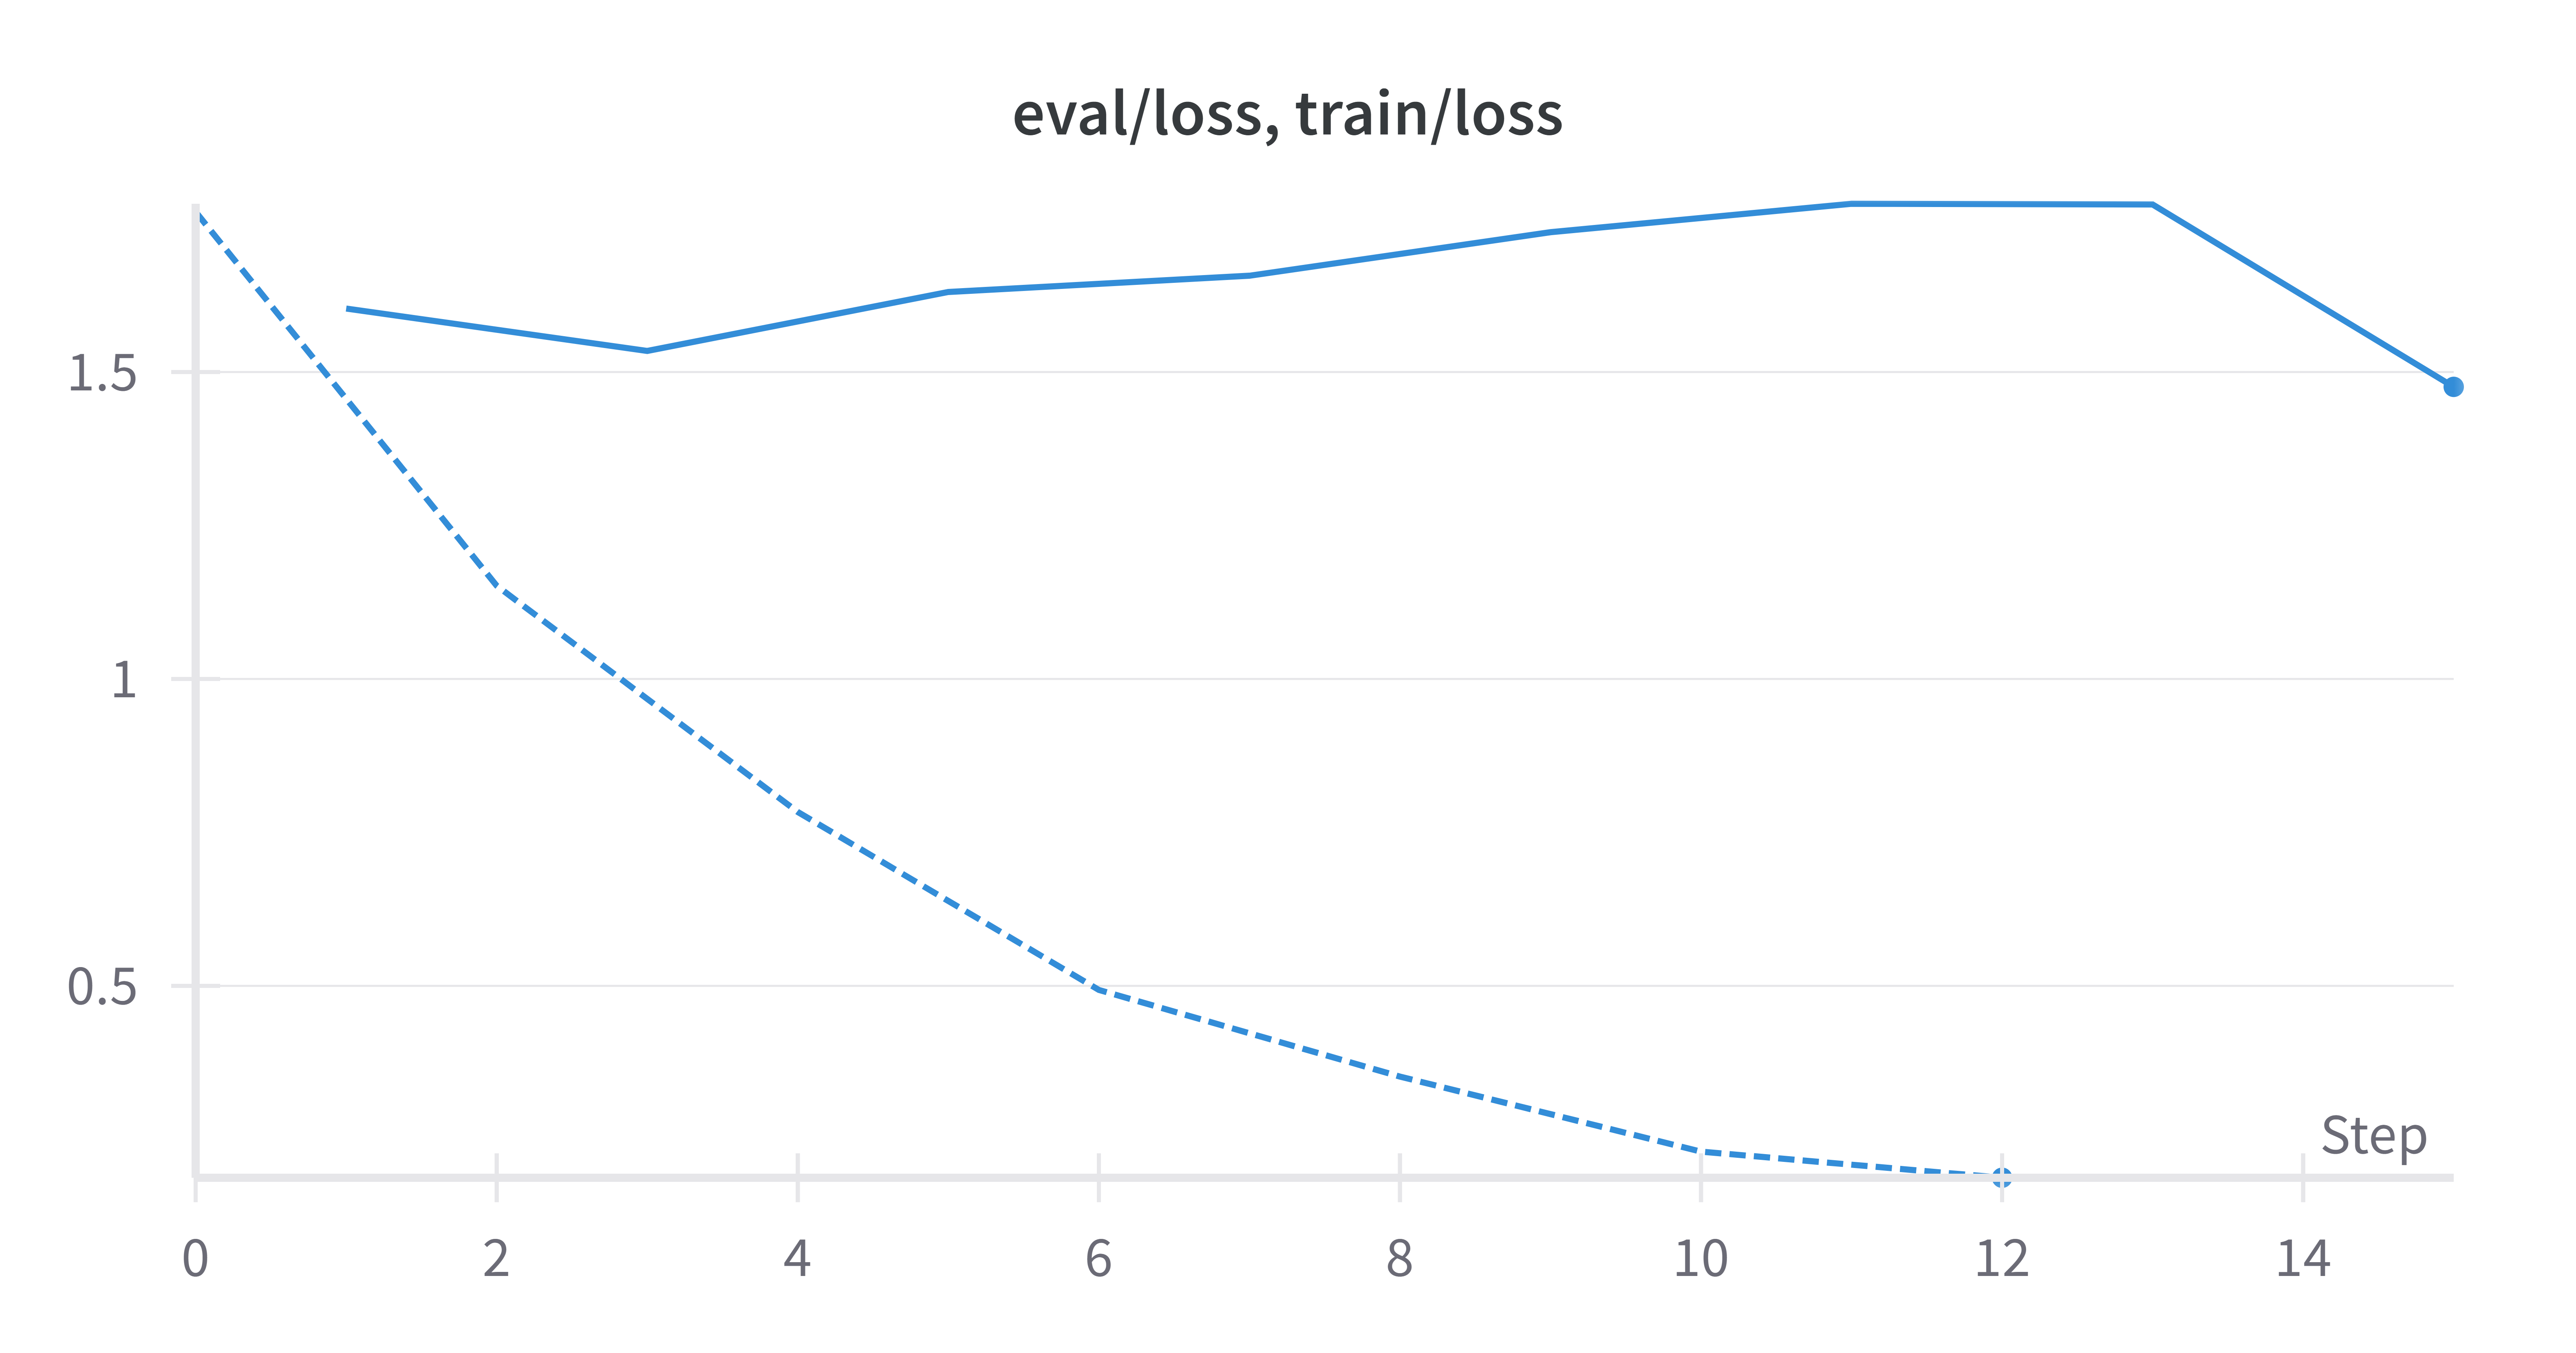


In [ ]:
trained_results = trainer.evaluate(test_dataset)
trained_results

{'eval_loss': 1.4758316278457642,
 'eval_runtime': 0.1739,
 'eval_samples_per_second': 57.488,
 'eval_steps_per_second': 17.246,
 'epoch': 6.888888888888889}

In [ ]:
model.eval()

prompts = test_dataset["instruction"]
outputs = test_dataset["output"]
generated_responses = generate_responses(prompts)

for prompt, output, response in zip(prompts, outputs, generated_responses):
    print(f"\n🔹 질문: {prompt}")
    print(f"\n🔹 응답: {output}")
    print(f"🔹 모델 응답: {response}")


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.



🔹 질문: 클라우드 AI (Cloud AI)이 무엇인지 설명해줘

🔹 응답: 클라우드 AI는 클라우드 컴퓨팅 환경에서 제공되는 인공지능 기술과 서비스를 의미합니다. 이를 통해 사용자는 대규모 데이터 처리, 기계 학습, 자연어 처리 등의 AI 기능을 쉽게 활용할 수 있습니다. 클라우드 AI는 일반적으로 높은 처리 능력과 저장 용량을 제공하여 기업과 개인이 복잡한 AI 모델을 학습시키고 운영할 수 있도록 돕습니다. 또한, 사용자는 필요에 따라 리소스를 확장하거나 축소할 수 있어 유연한 비용 관리를 할 수 있습니다. 대표적인 클라우드 AI 서비스에는 구글 클라우드 AI, 아마존 웹 서비스(AWS), 마이크로소프트 애저 등이 있습니다.
🔹 모델 응답: 클라우드 AI (Cloud AI)이 무엇인지 설명해줘def cloud_ai(cloud_ai):
    """클라우드 AI는 인공지능 (Artificial Intelligence, AI)이 클라우드 컴퓨팅을 통해 수행되는 인공지능 시스템입니다. 클라우드 AI는 컴퓨터 과학, 인공지능, 머신러닝, 딥러닝 등의 다양한 분야에서 활용됩니다. 클라우드 AI는 데이터 분석, 이미지 처리, 게임 인공지능, 의료 AI 등 다양한 분야에서 활용되고 있습니다. 클라우드 AI는 다양한 컴퓨팅 장치와 데이터베이스를 사용하여 빠르고 효율적으로 처리할 수 있어 더 빠르고 효과적인 인공지능 시스템을 만들 수 있습니다. 클라우드 AI는 데이터 분석, 의료 치료, 게임 디자인 등 다양한 분야에서 활용되고 있습니다. 클라우드 AI는 인공지능 기술을 활용하여 데이터를 분석하고 모델을 학습하여 인공지능 시스템을 만들고, 이를 통해 더 많은 데이터를 사용하여 더 잘 맞춘 모델을 만들 수 있습니다. 클라우드 AI는 인공지능의 발전을 촉진시키고, 더 많은 분야에서 활용될 수 있는 기회를 제공합니다. 클라우드 AI는 인

🔹 질문: API 기반 AI 서비스 (AI-as-a-Service)이 무엇인지 설명해줘

🔹 응답: API 기반 AI 서비스(AI-as-a-

In [ ]:
metrics = compute_metrics(generated_responses, outputs)

print("\n📊 Evaluation Metrics:")
print(f"🔹 BLEU Score: {metrics['bleu']:.4f}")
print(f"🔹 ROUGE-1: {metrics['rouge1']:.4f}")
print(f"🔹 ROUGE-2: {metrics['rouge2']:.4f}")
print(f"🔹 ROUGE-L: {metrics['rougeL']:.4f}")


📊 Evaluation Metrics:
🔹 BLEU Score: 0.0484
🔹 ROUGE-1: 0.3602
🔹 ROUGE-2: 0.2820
🔹 ROUGE-L: 0.3641


# Conclusion

- 1) Bleu 가 0.02에서 0.04로 증가한 것은 확인이 됩니다. 또한 훈련에서도 정상적으로 overfitting이 일어난 것을 확인할 수 있습니다.

- 2) 단, Rouge score는 오히려 하락한 것이 확인이 됩니다.

- 3) 출력의 형태는 육안으로 보았을 때 훨씬 나아진 것을 확인할 수 있습니다.

- 4) 이번 프로젝트의 목표는 해당 방식으로 훈련을 하여 aws에 모델을 올려 논문 요약 챗봇에 장착하는 것입니다.